In [1]:
#Installing suprise which is a library used for collaborative filtering
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162667 sha256=925767bce9971815a01f8dbf0c0b949f7919e3a5fdc4b24775c5d424dec298c9
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [2]:
# Importing all necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from surprise.model_selection import train_test_split

from surprise import Dataset, Reader, SVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

from surprise import accuracy
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score


### Loading the data

In [3]:
#Loading the data
masterdf=pd.read_csv("/content/drive/MyDrive/Data Science Bootcamp/Capstone-Project-Recommender/Recommnder/Transactions.csv")
masterdf.head(5)

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop
2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop
3,93274880719,271509,24-02-2014,11,6,-3,-1363,429.345,-4518.345,e-Shop
4,51750724947,273420,23-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop


In [4]:
custdf=pd.read_csv("/content/drive/MyDrive/Data Science Bootcamp/Capstone-Project-Recommender/Recommnder/Customer.csv")
custdf.head(5)

,customer_Id,DOB,Gender,city_code
0,268408,02-01-1970,M,4.0
1,269696,07-01-1970,F,8.0
2,268159,08-01-1970,F,8.0
3,270181,10-01-1970,F,2.0
4,268073,11-01-1970,M,1.0


In [5]:
proddf=pd.read_csv("/content/drive/MyDrive/Data Science Bootcamp/Capstone-Project-Recommender/Recommnder/prod_cat_info.csv")
proddf.head(5)

,prod_cat_code,prod_cat,prod_sub_cat_code,prod_subcat
0,1,Clothing,4,Mens
1,1,Clothing,1,Women
2,1,Clothing,3,Kids
3,2,Footwear,1,Mens
4,2,Footwear,3,Women


In [6]:
masterdf.shape

(23053, 10)

In [7]:
proddf.shape

(23, 4)

In [8]:
masterdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23053 entries, 0 to 23052
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_id    23053 non-null  int64  
 1   cust_id           23053 non-null  int64  
 2   tran_date         23053 non-null  object 
 3   prod_subcat_code  23053 non-null  int64  
 4   prod_cat_code     23053 non-null  int64  
 5   Qty               23053 non-null  int64  
 6   Rate              23053 non-null  int64  
 7   Tax               23053 non-null  float64
 8   total_amt         23053 non-null  float64
 9   Store_type        23053 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.8+ MB


### Data Preprocessing

In [9]:
masterdf.duplicated().sum()

13

In [10]:
masterdf.drop_duplicates(inplace=True)

In [11]:
masterdf.duplicated().sum()

0

In [12]:
masterdf.isnull().sum()

transaction_id      0
cust_id             0
tran_date           0
prod_subcat_code    0
prod_cat_code       0
Qty                 0
Rate                0
Tax                 0
total_amt           0
Store_type          0
dtype: int64

In [13]:
#Copying the values from Rate and storing it as a new column Ratings
masterdf['Ratings']=masterdf['Rate']

In [14]:
#Remove negative values
masterdf['Qty'] = masterdf['Qty'].abs()
masterdf['Rate'] = masterdf['Rate'].abs()

In [15]:
masterdf['Qty']

0        5
1        5
2        2
3        3
4        2
        ..
23048    1
23049    1
23050    4
23051    3
23052    1
Name: Qty, Length: 23040, dtype: int64

In [16]:
masterdf['Rate']

0         772
1        1497
2         791
3        1363
4         791
         ... 
23048    1264
23049     677
23050    1052
23051    1142
23052     447
Name: Rate, Length: 23040, dtype: int64

In [17]:
masterdf['transaction_id'] = masterdf['transaction_id'].astype(str)
masterdf['prod_cat_code'] = masterdf['prod_cat_code'].astype(str)
masterdf['prod_subcat_code'] = masterdf['prod_subcat_code'].astype(str)

In [18]:
proddf['prod_cat_code'] = proddf['prod_cat_code'].astype(str)
proddf['prod_sub_cat_code'] = proddf['prod_sub_cat_code'].astype(str)

In [19]:
masterdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23040 entries, 0 to 23052
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_id    23040 non-null  object 
 1   cust_id           23040 non-null  int64  
 2   tran_date         23040 non-null  object 
 3   prod_subcat_code  23040 non-null  object 
 4   prod_cat_code     23040 non-null  object 
 5   Qty               23040 non-null  int64  
 6   Rate              23040 non-null  int64  
 7   Tax               23040 non-null  float64
 8   total_amt         23040 non-null  float64
 9   Store_type        23040 non-null  object 
 10  Ratings           23040 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 2.1+ MB


In [20]:
proddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   prod_cat_code      23 non-null     object
 1   prod_cat           23 non-null     object
 2   prod_sub_cat_code  23 non-null     object
 3   prod_subcat        23 non-null     object
dtypes: object(4)
memory usage: 864.0+ bytes


### **Customer Table Preprocessing**

In [21]:
custdf.head(3)

,customer_Id,DOB,Gender,city_code
0,268408,02-01-1970,M,4.0
1,269696,07-01-1970,F,8.0
2,268159,08-01-1970,F,8.0


In [22]:
custdf.shape

(5647, 4)

In [23]:
custdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5647 entries, 0 to 5646
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_Id  5647 non-null   int64  
 1   DOB          5647 non-null   object 
 2   Gender       5645 non-null   object 
 3   city_code    5645 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 176.6+ KB


In [24]:
custdf.duplicated().sum()

0

In [25]:
custdf.isnull().sum()

customer_Id    0
DOB            0
Gender         2
city_code      2
dtype: int64

In [26]:
# Find null values in city code column
len(custdf[custdf['city_code'].isnull()])

2

In [27]:
custdf['city_code'].unique()

array([ 4.,  8.,  2.,  1.,  5.,  9.,  7., 10.,  6.,  3., nan])

In [28]:
len(custdf['customer_Id'].unique())

5647

### **Transactions Table Visualization**

In [29]:
masterdf.describe()

,cust_id,Qty,Rate,Tax,total_amt,Ratings
count,23040.000000,23040.000000,23040.000000,23040.000000,23040.000000,23040.000000
mean,271021.880252,3.007031,787.126215,248.677488,2109.865226,637.094965
std,2431.573668,1.420474,415.761913,187.188311,2505.610295,621.727374
min,266783.000000,1.000000,70.000000,7.350000,-8270.925000,-1499.000000
25%,268935.000000,2.000000,426.000000,98.280000,762.450000,312.000000
50%,270980.500000,3.000000,791.000000,199.080000,1756.950000,710.000000
75%,273114.250000,4.000000,1150.000000,365.767500,3570.255000,1109.000000
max,275265.000000,5.000000,1500.000000,787.500000,8287.500000,1500.000000


In [30]:
# Correlation function
correlation_matrix = masterdf.corr()

<ipython-input-30-8d78419a3cc7>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = masterdf.corr()


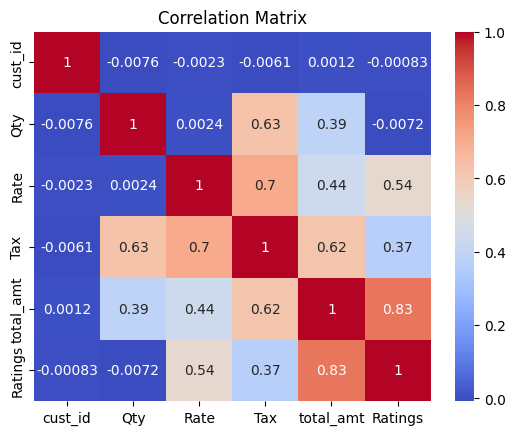

In [31]:
# Heatmap to understand correlation between columns
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

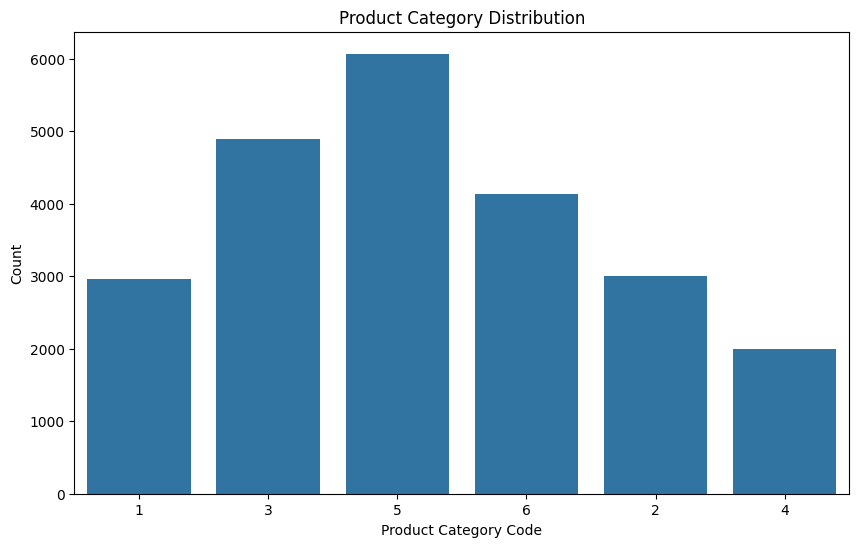

In [32]:
# Bar plot for product categories with prod_cat_code and count
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='prod_cat_code', data=masterdf)
plt.title("Product Category Distribution")
plt.xlabel("Product Category Code")
plt.ylabel("Count")
plt.show()

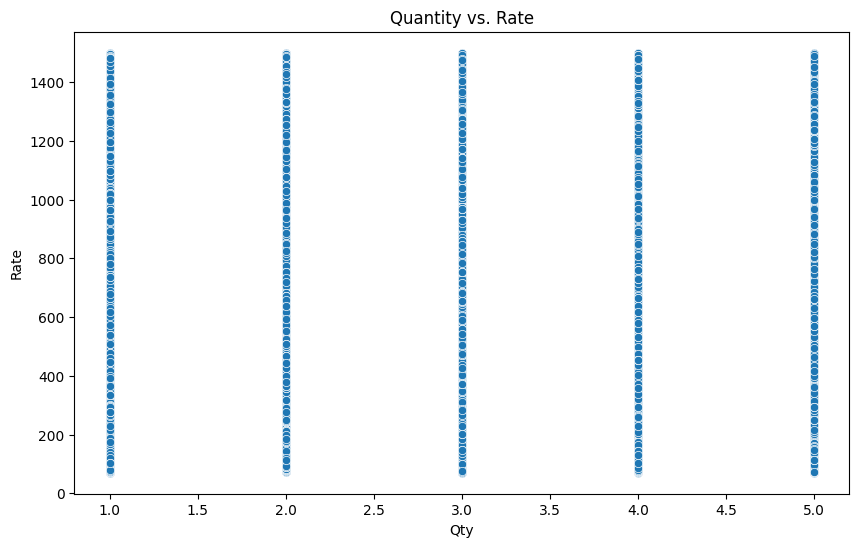

In [33]:
#Scatter plot for Quantity vs. Rate
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Qty', y='Rate', data=masterdf)
plt.title("Quantity vs. Rate")
plt.show()

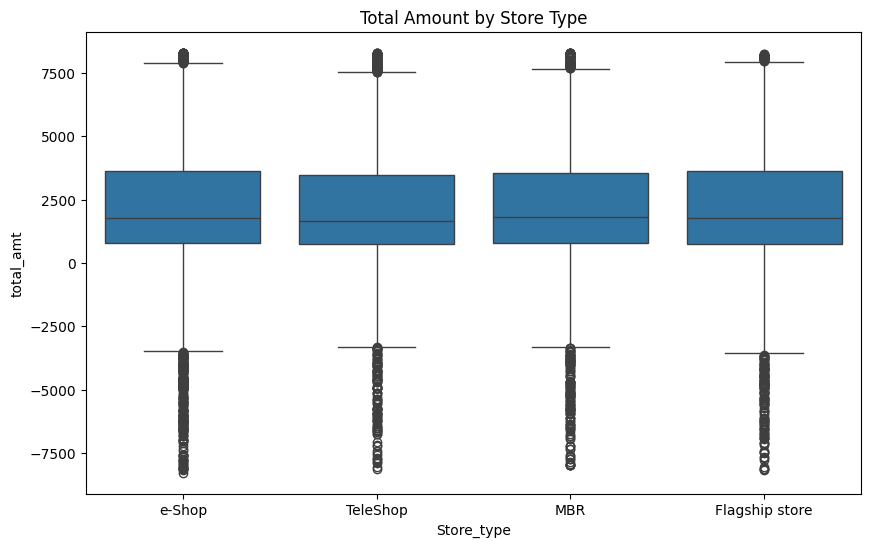

In [34]:
# Box plot for Total Amount by Store type
plt.figure(figsize=(10, 6))
sns.boxplot(x='Store_type', y='total_amt', data=masterdf)
plt.title("Total Amount by Store Type")
plt.show()

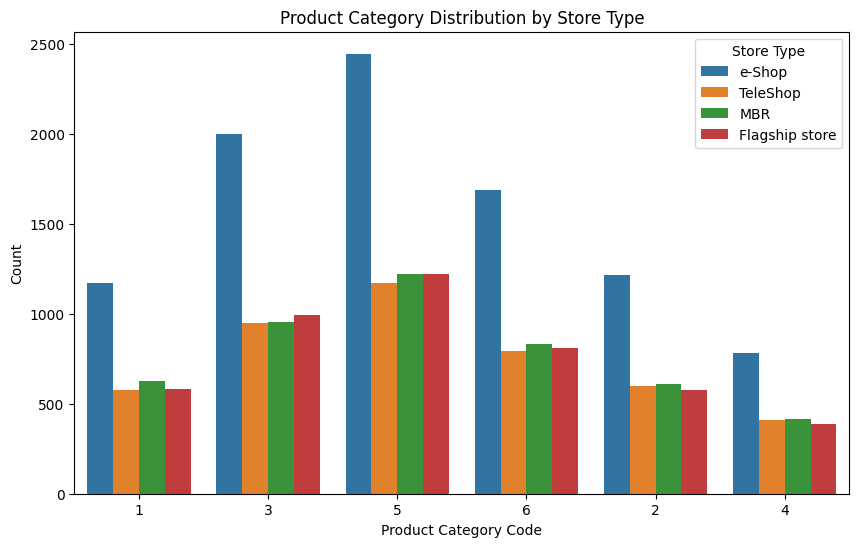

In [35]:
# Bar plot for product categories with prod_cat_code and Store_type
plt.figure(figsize=(10, 6))
sns.countplot(x='prod_cat_code', hue='Store_type', data=masterdf)
plt.title("Product Category Distribution by Store Type")
plt.xlabel("Product Category Code")
plt.ylabel("Count")
plt.legend(title="Store Type")
plt.show()

### **Encoding and Standardization**

In [36]:
#Label Encoding the Store Type
masterdf['Store_type_code'] = pd.factorize(masterdf['Store_type'])[0]
masterdf.head(3)

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,Ratings,Store_type_code
0,80712190438,270351,28-02-2014,1,1,5,772,405.300,-4265.300,e-Shop,-772,0
1,29258453508,270384,27-02-2014,5,3,5,1497,785.925,-8270.925,e-Shop,-1497,0
2,51750724947,273420,24-02-2014,6,5,2,791,166.110,-1748.110,TeleShop,-791,1


In [37]:
masterdf[['Store_type', 'Store_type_code']].drop_duplicates()

,Store_type,Store_type_code
0,e-Shop,0
2,TeleShop,1
8,MBR,2
17,Flagship store,3


In [38]:
masterdf['Store_type'].unique()

array(['e-Shop', 'TeleShop', 'MBR', 'Flagship store'], dtype=object)

In [39]:
masterdf['Store_type'] = masterdf['Store_type'].astype(str)

In [40]:
# Convert 'DOB'from customer table to datetime format
custdf['DOB'] = pd.to_datetime(custdf['DOB'])

<ipython-input-40-61a2ab2a5e1e>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  custdf['DOB'] = pd.to_datetime(custdf['DOB'])


In [41]:
masterdf['tran_date'].dtypes

dtype('O')

In [42]:
# Convert 'tran_date' to datetime format
masterdf['tran_date'] =  pd.DatetimeIndex(masterdf['tran_date'], dayfirst=True).date

In [43]:
masterdf['tran_date'].dtypes

dtype('O')

In [44]:
masterdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23040 entries, 0 to 23052
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_id    23040 non-null  object 
 1   cust_id           23040 non-null  int64  
 2   tran_date         23040 non-null  object 
 3   prod_subcat_code  23040 non-null  object 
 4   prod_cat_code     23040 non-null  object 
 5   Qty               23040 non-null  int64  
 6   Rate              23040 non-null  int64  
 7   Tax               23040 non-null  float64
 8   total_amt         23040 non-null  float64
 9   Store_type        23040 non-null  object 
 10  Ratings           23040 non-null  int64  
 11  Store_type_code   23040 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 2.3+ MB


In [45]:
# Calculate total net sales from quantity and based price (minus Tax, as it may be different from city to city)
masterdf['Net Sales'] = masterdf['Qty'] * masterdf['Rate']

In [46]:
masterdf['Material'] = masterdf['prod_cat_code'] + '-' + masterdf['prod_subcat_code']+ '-' + masterdf['Store_type']
masterdf[['prod_cat_code','prod_subcat_code', 'Store_type', 'Material']].drop_duplicates(subset='Material').head(5)

,prod_cat_code,prod_subcat_code,Store_type,Material
0,1,1,e-Shop,1-1-e-Shop
1,3,5,e-Shop,3-5-e-Shop
2,5,6,TeleShop,5-6-TeleShop
3,6,11,e-Shop,6-11-e-Shop
5,3,8,TeleShop,3-8-TeleShop


In [47]:
len(masterdf['Material'].unique())

92

In [48]:
masterdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23040 entries, 0 to 23052
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_id    23040 non-null  object 
 1   cust_id           23040 non-null  int64  
 2   tran_date         23040 non-null  object 
 3   prod_subcat_code  23040 non-null  object 
 4   prod_cat_code     23040 non-null  object 
 5   Qty               23040 non-null  int64  
 6   Rate              23040 non-null  int64  
 7   Tax               23040 non-null  float64
 8   total_amt         23040 non-null  float64
 9   Store_type        23040 non-null  object 
 10  Ratings           23040 non-null  int64  
 11  Store_type_code   23040 non-null  int64  
 12  Net Sales         23040 non-null  int64  
 13  Material          23040 non-null  object 
dtypes: float64(2), int64(6), object(6)
memory usage: 2.6+ MB


## Content based Filtering

In [49]:
reader = Reader(rating_scale=(masterdf['Qty'].min(), masterdf['Qty'].max()))
data = Dataset.load_from_df(masterdf[['cust_id', 'Material', 'Qty']], reader)

In [50]:
# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [51]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(masterdf['Material'])

In [52]:
# Calculate cosine similarity between items
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [53]:
# Initialize an empty DataFrame to store recommendations
recommendations_df = pd.DataFrame(columns=['Material', 'Recommended_Items'])

In [54]:
# Function to calculate metrics for content-based filtering
def calculate_metrics(item_id, cosine_similarities, k=5):
    idx = masterdf[masterdf['Material'] == item_id].index[0]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_k_indices = [i[0] for i in sim_scores[:k]]

    relevant_items = set(masterdf[masterdf['Material'] == item_id]['cust_id'])
    recommended_items = set(masterdf['cust_id'].iloc[top_k_indices])

    # Precision
    precision = len(relevant_items.intersection(recommended_items)) / len(recommended_items) if len(recommended_items) > 0 else 0.0

    # Recall
    recall = len(relevant_items.intersection(recommended_items)) / len(relevant_items) if len(relevant_items) > 0 else 0.0

    # F1 Score
    true_positive = len(relevant_items.intersection(recommended_items))
    false_positive = len(recommended_items) - true_positive
    false_negative = len(relevant_items) - true_positive
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0.0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    # Mean Average Precision
    y_true = [1 if cust_id in relevant_items else 0 for cust_id in masterdf['cust_id'].iloc[top_k_indices]]
    average_precision = average_precision_score(y_true, range(1, k+1)) if sum(y_true) > 0 else 0.0

    # Recommended items
    recommended_items_list = masterdf['Material'].iloc[top_k_indices].tolist()

    # Store recommendations in the DataFrame
    recommendations_df.loc[len(recommendations_df)] = [item_id, recommended_items_list]

    return precision, recall, f1_score, average_precision

In [55]:
# Calculate metrics for all material codes
all_material_codes = masterdf['Material'].unique()
total_precision = 0
total_recall = 0
total_f1_score = 0
total_average_precision = 0

for item_id in all_material_codes:
    precision, recall, f1_score, average_precision = calculate_metrics(item_id, cosine_similarities, k=5)
    total_precision += precision
    total_recall += recall
    total_f1_score += f1_score
    total_average_precision += average_precision

In [56]:
# Calculate average metrics across all items
average_precision = total_precision / len(all_material_codes)
average_recall = total_recall / len(all_material_codes)
average_f1_score = total_f1_score / len(all_material_codes)
average_average_precision = total_average_precision / len(all_material_codes)

In [57]:
# Display the recommendations DataFrame
print("\nRecommendations DataFrame:")
print(recommendations_df)


Recommendations DataFrame:
              Material                                  Recommended_Items
0           1-1-e-Shop  [1-1-e-Shop, 3-5-e-Shop, 3-8-e-Shop, 3-5-e-Sho...
1           3-5-e-Shop  [1-1-e-Shop, 3-5-e-Shop, 3-8-e-Shop, 3-5-e-Sho...
2         5-6-TeleShop  [5-6-TeleShop, 5-6-TeleShop, 3-8-TeleShop, 2-1...
3          6-11-e-Shop  [6-11-e-Shop, 6-11-e-Shop, 5-11-e-Shop, 6-11-e...
4         3-8-TeleShop  [5-6-TeleShop, 5-6-TeleShop, 3-8-TeleShop, 2-1...
..                 ...                                                ...
87             3-9-MBR      [1-3-MBR, 2-1-MBR, 4-4-MBR, 2-1-MBR, 2-4-MBR]
88             1-4-MBR      [1-3-MBR, 2-1-MBR, 4-4-MBR, 2-1-MBR, 2-4-MBR]
89  5-7-Flagship store  [4-4-Flagship store, 2-3-Flagship store, 2-3-F...
90             2-3-MBR      [1-3-MBR, 2-1-MBR, 4-4-MBR, 2-1-MBR, 2-4-MBR]
91  1-1-Flagship store  [4-4-Flagship store, 2-3-Flagship store, 2-3-F...

[92 rows x 2 columns]


## Collaborative Filtering

In [58]:
collab_df = masterdf[['cust_id', 'Material']]

# Add a placeholder column for ratings
collab_df['Rating'] = 1

# Create a surprise Reader and Dataset
reader = Reader(rating_scale=(1, 1))

# Use 'Material' as item, 'cust_id' as user, and 'Rating' as rating
data = Dataset.load_from_df(collab_df[['cust_id', 'Material', 'Rating']], reader)

<ipython-input-58-779cb93176ef>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collab_df['Rating'] = 1


In [59]:
# Build and train the collaborative filtering model (using Singular Value Decomposition)
model = SVD()
model.fit(trainset)

In [60]:
# Make predictions on the test set
predictions = model.test(testset)

In [61]:
# Function to calculate metrics for collaborative filtering and get top recommendations
def calculate_metrics_with_recommendations(predictions, k=5):
    top_recs = defaultdict(list)

    for uid, iid, true_qty, est_qty, _ in predictions:
        top_recs[uid].append((iid, est_qty))

    total_user_relevant_items = 0
    total_user_recommended_items = 0
    total_user_relevant_and_recommended_items = 0
    user_recommendations = defaultdict(list)

    for uid, user_ratings in top_recs.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        relevant_items = set(iid for iid, _ in user_ratings[:k] if iid in masterdf[masterdf['cust_id'] == uid]['Material'].values)
        recommended_items = set(iid for iid, _ in user_ratings[:k])

        total_user_relevant_items += len(relevant_items)
        total_user_recommended_items += min(k, len(recommended_items))
        total_user_relevant_and_recommended_items += len(relevant_items.intersection(recommended_items))

        # Store recommendations for each user
        user_recommendations[uid] = [iid for iid, _ in user_ratings[:k]]

    # Calculate Recall@k
    recall = total_user_relevant_and_recommended_items / total_user_relevant_items if total_user_relevant_items > 0 else 0.0

    # Calculate Precision@k
    precision = total_user_relevant_and_recommended_items / total_user_recommended_items if total_user_recommended_items > 0 else 0.0

    # Calculate F1 Score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    # Calculate Mean Average Precision
    y_true = [1 if iid in masterdf[masterdf['cust_id'] == uid]['Material'].values else 0 for uid, iid, _, _, _ in predictions]
    average_precision = average_precision_score(y_true, [1] * len(predictions)) if sum(y_true) > 0 else 0.0

    return precision, recall, f1, average_precision, user_recommendations

In [62]:
# Calculate metrics and get recommendations for collaborative filtering
precision_at_5, recall_at_5, f1_at_5, average_precision_at_5, user_recommendations = calculate_metrics_with_recommendations(predictions, k=5)

In [63]:
# Create a DataFrame to store recommendations
recommendations_df = pd.DataFrame(columns=['cust_id', 'Collaborative Recommendations'])

In [64]:
# Populate the recommendations DataFrame
for uid, recs in user_recommendations.items():
    recommendations_df = recommendations_df.append({'cust_id': uid, 'Collaborative Recommendations': recs}, ignore_index=True)

Streaming output truncated to the last 5000 lines.
<ipython-input-64-741fd24b0064>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendations_df = recommendations_df.append({'cust_id': uid, 'Collaborative Recommendations': recs}, ignore_index=True)
<ipython-input-64-741fd24b0064>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendations_df = recommendations_df.append({'cust_id': uid, 'Collaborative Recommendations': recs}, ignore_index=True)
<ipython-input-64-741fd24b0064>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendations_df = recommendations_df.append({'cust_id': uid, 'Collaborative Recommendations': recs}, ignore_index=True)
<ipython-input-64-741fd24b0064>:3: FutureWarning: The frame.append met

In [65]:
# Display the recommendations DataFrame
print("\nRecommendations DataFrame:")
print(recommendations_df.head())


Recommendations DataFrame:
  cust_id Collaborative Recommendations
0  272267          [1-1-Flagship store]
1  275225        [3-10-MBR, 3-4-e-Shop]
2  272603       [2-4-MBR, 3-9-TeleShop]
3  269758          [5-10-MBR, 5-10-MBR]
4  273536     [4-1-e-Shop, 5-11-e-Shop]


## Hybrid Filtering

In [66]:
# Collaborative Filtering

reader = Reader(rating_scale=(masterdf['Qty'].min(), masterdf['Qty'].max()))
data = Dataset.load_from_df(masterdf[['cust_id', 'Material', 'Qty']], reader)

# Spliting data as testset and trainset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

model_collaborative = SVD()
model_collaborative.fit(trainset)

predictions_collaborative = model_collaborative.test(testset)

In [67]:
# Content-Based Filtering

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(masterdf['Material'])
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [68]:
# Function to get top content-based recommendations for each user
def get_content_based_recommendations(cosine_similarities, uid, k=5):
    idx = masterdf[masterdf['cust_id'] == uid].index[0]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_k_indices = [i[0] for i in sim_scores[:k]]
    content_based_top_k = list(masterdf['Material'].iloc[top_k_indices])
    return content_based_top_k

In [69]:
# Function to get top collaborative recommendations for each user
def get_collaborative_recommendations(predictions, uid, k=5):
    top_recs = []
    for _, iid, _, est_qty, _ in predictions:
        top_recs.append((iid, est_qty))

    # Sort the collaborative predictions by estimated quantity in descending order
    top_recs.sort(key=lambda x: x[1], reverse=True)

    collaborative_top_k = [iid for iid, _ in top_recs[:k]]
    return collaborative_top_k

In [70]:
# Reset index to make merging easier
masterdf_reset = masterdf.reset_index(drop=True)

# Create DataFrames for content-based and collaborative predictions
content_based_df = pd.DataFrame(columns=['cust_id', 'Content-Based Recommendations'])
collaborative_df = pd.DataFrame(columns=['cust_id', 'Collaborative Recommendations'])

for uid in masterdf_reset['cust_id'].unique():
    content_based_top_k = get_content_based_recommendations(cosine_similarities, uid, k=5)
    collaborative_top_k = get_collaborative_recommendations(predictions_collaborative, uid, k=5)

    content_based_df = content_based_df.append({'cust_id': uid, 'Content-Based Recommendations': content_based_top_k}, ignore_index=True)
    collaborative_df = collaborative_df.append({'cust_id': uid, 'Collaborative Recommendations': collaborative_top_k}, ignore_index=True)


Streaming output truncated to the last 5000 lines.
<ipython-input-70-d7b5d32f34a8>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  content_based_df = content_based_df.append({'cust_id': uid, 'Content-Based Recommendations': content_based_top_k}, ignore_index=True)
<ipython-input-70-d7b5d32f34a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  collaborative_df = collaborative_df.append({'cust_id': uid, 'Collaborative Recommendations': collaborative_top_k}, ignore_index=True)
<ipython-input-70-d7b5d32f34a8>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  content_based_df = content_based_df.append({'cust_id': uid, 'Content-Based Recommendations': content_based_top_k}, ignore_index=True)
<ipython-input-70-d7b5d32f34a8>:13

In [71]:
# Merge DataFrames on 'cust_id'
merged_df = pd.merge(content_based_df, collaborative_df, on='cust_id')

# Function to calculate hybrid recommendations with weighted combination
def get_weighted_hybrid_recommendations(row, weight_content_based=0.5, weight_collaborative=0.5):
    content_based_recommendations = row['Content-Based Recommendations']
    collaborative_recommendations = row['Collaborative Recommendations']

    # Apply weights to each recommendation list
    weighted_content_based = [item for item in content_based_recommendations]
    weighted_collaborative = [item for item in collaborative_recommendations]

    # Combine lists with weighted approach
    hybrid_recommendations = list(set(weighted_content_based + weighted_collaborative))

    return hybrid_recommendations

In [72]:
# Using a row from merged_df
example_row = merged_df.iloc[0]

# Call the function with the row
resulting_hybrid_recommendations = get_weighted_hybrid_recommendations(example_row)

# Print the result
print(resulting_hybrid_recommendations)
print("DataFrame Size:", len(resulting_hybrid_recommendations))

['1-3-e-Shop', '2-1-e-Shop', '3-5-e-Shop', '3-8-e-Shop', '2-4-e-Shop', '5-12-e-Shop', '5-6-e-Shop', '1-1-e-Shop']
DataFrame Size: 8


In [73]:
# Apply the function to create hybrid recommendations
merged_df['Hybrid Recommendations'] = merged_df.apply(get_weighted_hybrid_recommendations, axis=1)

# Print the DataFrame with hybrid recommendations
print(merged_df[['cust_id', 'Hybrid Recommendations']])

     cust_id                             Hybrid Recommendations
0     270351  [1-3-e-Shop, 2-1-e-Shop, 3-5-e-Shop, 3-8-e-Sho...
1     270384  [1-3-e-Shop, 2-1-e-Shop, 3-5-e-Shop, 3-8-e-Sho...
2     273420  [3-8-TeleShop, 1-3-e-Shop, 5-6-TeleShop, 2-1-e...
3     271509  [1-3-e-Shop, 2-1-e-Shop, 5-11-e-Shop, 2-4-e-Sh...
4     272357  [3-8-TeleShop, 1-3-e-Shop, 5-6-TeleShop, 2-1-e...
...      ...                                                ...
5501  274931  [1-3-e-Shop, 2-1-e-Shop, 3-5-e-Shop, 3-8-e-Sho...
5502  267902  [3-8-TeleShop, 1-3-e-Shop, 5-6-TeleShop, 2-1-e...
5503  269556  [1-3-e-Shop, 6-12-e-Shop, 2-1-e-Shop, 2-4-e-Sh...
5504  274935  [1-3-e-Shop, 2-1-e-Shop, 2-4-e-Shop, 4-4-MBR, ...
5505  273723  [1-3-e-Shop, 2-1-e-Shop, 3-5-e-Shop, 3-8-e-Sho...

[5506 rows x 2 columns]


In [74]:
def calculate_metrics(true_labels, hybrid_recommendations):
    y_true = []
    y_pred = []

    for uid, qty in zip(true_labels['cust_id'], true_labels['Qty']):
        true_items = {qty} if pd.notna(qty) else set()
        hybrid_items = set(hybrid_recommendations[hybrid_recommendations['cust_id'] == uid]['Hybrid Recommendations'].values[0])

        y_true.append(true_items)
        y_pred.append(hybrid_items)

    # Flatten the lists
    y_true_flat = [item for sublist in y_true for item in sublist]
    y_pred_flat = [item for sublist in y_pred for item in sublist]

    # Calculate precision, recall, F1 score, and mean average precision
    precision_value = precision_score(y_true_flat, y_pred_flat, average='micro', zero_division=1)
    recall_value = recall_score(y_true_flat, y_pred_flat, average='micro', zero_division=1)
    f1_value_result = f1_score(y_true_flat, y_pred_flat, average='micro', zero_division=1)
    average_precision_value = average_precision_score(y_true_flat, y_pred_flat, average='micro', zero_division=1)

    return precision_value, recall_value, f1_value_result, average_precision_value

In [75]:
true_labels = {
    'cust_id': masterdf['cust_id'].head(5506),
    'Qty': masterdf['Qty'].head(5506)
}

In [76]:
true_labels_df = pd.DataFrame(true_labels)

hybrid_recommendations_df = pd.DataFrame(merged_df[['cust_id', 'Hybrid Recommendations']])

In [77]:
# Display the shape of Dataframe
print("True Labels Shape:", true_labels_df.shape)
print("Recommendations DataFrame Shape:", merged_df[['cust_id', 'Hybrid Recommendations']].shape)

True Labels Shape: (5506, 2)
Recommendations DataFrame Shape: (5506, 2)


### Evaluation Metrics


In [78]:
# Display metrics for content-based filtering
print(f"Average Precision for content-based filtering: {average_precision}")
print(f"Average Recall for content-based filtering: {average_recall}")
print(f"Average F1 Score for content-based filtering: {average_f1_score}")
print(f"Average Mean Average Precision for content-based filtering: {average_average_precision}")

Average Precision for content-based filtering: 0.2103260869565217
Average Recall for content-based filtering: 0.0048295074006164335
Average F1 Score for content-based filtering: 0.009424058929195607
Average Mean Average Precision for content-based filtering: 0.3304045893719806


In [79]:
# Display metrics for collaborative filtering
print(f"Precision@5 for collaborative filtering: {precision_at_5}")
print(f"Recall@5 for collaborative filtering: {recall_at_5}")
print(f"F1 Score@5 for collaborative filtering: {f1_at_5}")
print(f"Mean Average Precision@5 for collaborative filtering: {average_precision_at_5}")

Precision@5 for collaborative filtering: 1.0
Recall@5 for collaborative filtering: 1.0
F1 Score@5 for collaborative filtering: 1.0
Mean Average Precision@5 for collaborative filtering: 1.0


In [80]:
# These metrics for collaborative filtering at the top-5 recommendations are perfect, suggesting that the system is providing highly accurate and complete recommendations for users.
# A precision, recall, F1 score, and mean average precision of 1.0 indicate that all recommended items are relevant, and there are no false positives or false negatives.